# Explore here

In [47]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:
df = pd.read_csv('../data/raw/sales.csv')
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [49]:
df.describe()

,sales
count,366.000000
mean,524.963968
std,275.089698
min,53.803211
25%,290.186822
50%,520.699468
75%,763.289263
max,1000.482785


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [51]:
df.duplicated().sum()

np.int64(0)

In [52]:
df.nunique()

date     366
sales    366
dtype: int64

In [53]:
df['sales'].isnull().sum()  # Verifica cuántos valores faltan

np.int64(0)

In [54]:
# Asegúrate de que tenga valores reales
df['sales'].head()

0    55.292157
1    53.803211
2    58.141693
3    64.530899
4    66.013633
Name: sales, dtype: float64

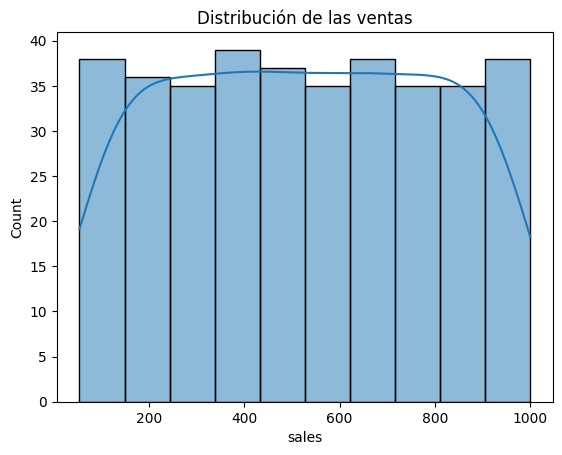

In [55]:
sns.histplot(df['sales'], bins='auto', kde=True)
plt.title("Distribución de las ventas")
plt.show()

Parece todo uniforme y adecuado para poder trabajar con el dataset sin hacer mas ajustes por ahora.
Hay estructura suficiente como para avanzar con un modelado.

Paso 2: Construye y analiza la serie temporal
Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:
¿Cuál es el tensor de la serie temporal?
¿Cuál es la tendencia?
¿Es estacionaria?
¿Existe variabilidad o presencia de ruido?

In [56]:
# Conversión de la columna 'date' a tipo datetime y orden cronológico
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [57]:
# Establecer la fecha como índice y ajustar frecuencia diaria
df.set_index('date', inplace=True)
df = df.asfreq('D')

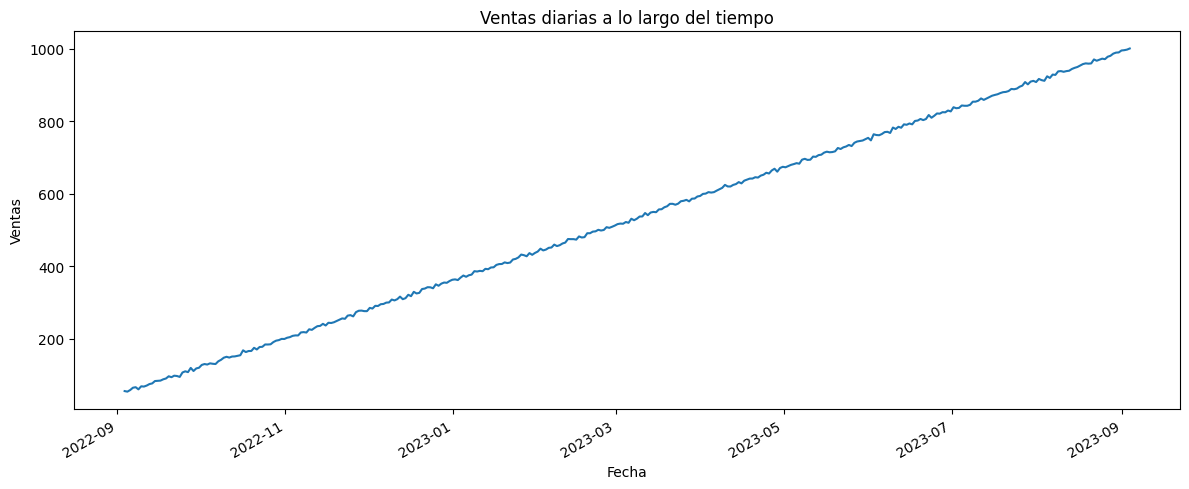

In [58]:
# Visualización básica de las ventas diarias
plt.figure(figsize=(12, 5))
df['sales'].plot()
plt.title('Ventas diarias a lo largo del tiempo')
plt.ylabel('Ventas')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

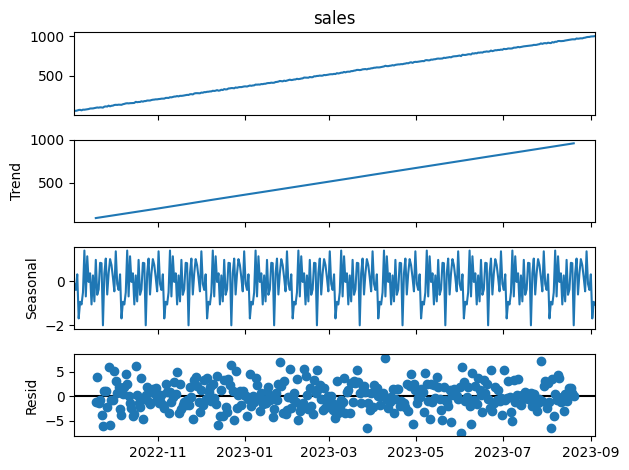

In [59]:
# Análisis de estacionariedad y descomposición.
# Descomposición aditiva con periodo mensual aproximado (30 días)
resultado = seasonal_decompose(df['sales'], model='additive', period=30)
resultado.plot()
plt.tight_layout()
plt.show()

In [60]:
# Verificamos la estacionariedad con la prueba Dickey-Fuller.
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    return pd.Series(result[0:4], index=["Estadístico de prueba", "p-value", "# lags usados", "Nº observaciones"])

print(test_stationarity(df['sales']))

Estadístico de prueba      0.545414
p-value                    0.986190
# lags usados             13.000000
Nº observaciones         352.000000
dtype: float64


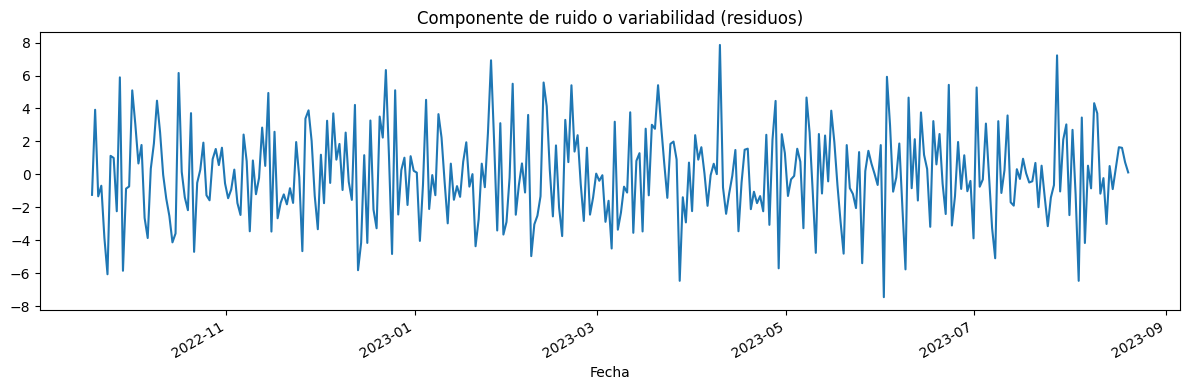

In [61]:
# Visualización de los residuos (ruido)
resultado.resid.plot(figsize=(12, 4), title='Componente de ruido o variabilidad (residuos)')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

¿Cuál es el tensor de la serie temporal?.
El dataset contiene 366 registros consecutivos con frecuencia diaria (asfreq('D')), lo que significa que el tensor es diario.

¿Cuál es la tendencia?.
La serie muestra un "crecimiento progresivo" en las ventas a lo largo del tiempo.
El gráfico de la serie temporal completa nos lo muestra y el componente de tendencia en la descomposición estacional (seasonal_decompose).
Esto indica que la empresa ha mantenido una trayectoria positiva en ventas.

¿Es estacionaria?.
Aplicando la prueba de Dickey-Fuller vemos como: 
stadístico: 0.5454
p-value: 0.9861 (≫ 0.05)
Por tanto, la serie no es estacionaria, ya que mantiene una tendencia clara y la hipótesis nula (de no estacionariedad) no puede rechazarse.

¿Existe variabilidad o presencia de ruido?.
Sí, pero de forma controlada.

3: Entrenamiento del modelo ARIMA

He utilizado prophet ya que ARIMA me da problemas para importarlo, he decidido usar Prophet ya que en la clase se hablo de el para este tipo de ejercicios.

In [62]:
df_prophet = df.reset_index().rename(columns={'date': 'ds', 'sales': 'y'})
modelo = Prophet()
modelo.fit(df_prophet)

20:46:07 - cmdstanpy - INFO - Chain [1] start processing
20:46:07 - cmdstanpy - INFO - Chain [1] done processing


4: Predicción y evaluación

RMSE: 2.63


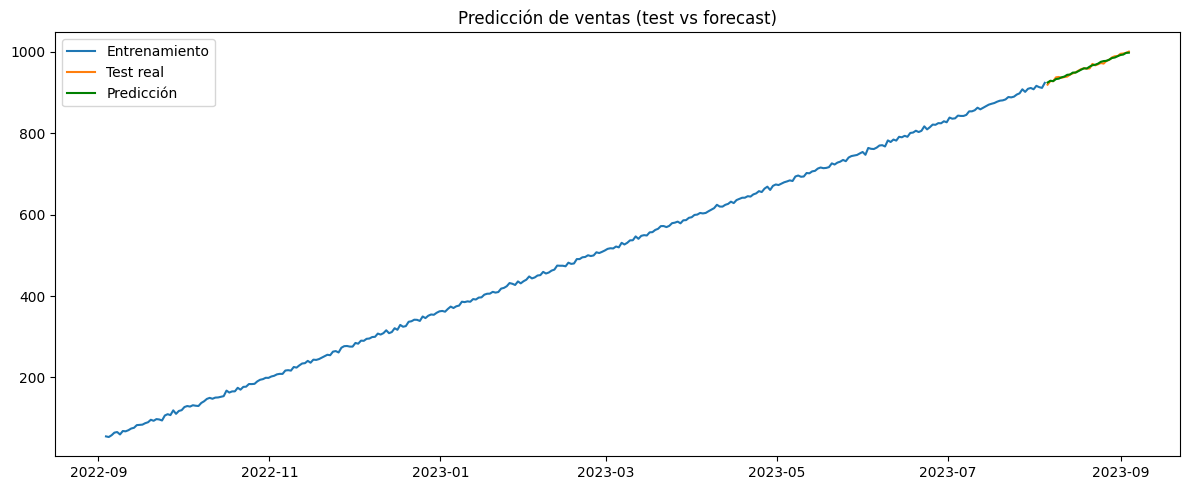

In [63]:
# Dividimos en entrenamiento y prueba
train = df['sales'][:-30]
test = df['sales'][-30:]

# Entrenamos modelo con datos de entrenamiento
modelo_final = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,30),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()
# Predicción de los últimos 30 días
preds = modelo_final.forecast(steps=30)

# Evaluación con RMSE
rmse = np.sqrt(mean_squared_error(test, preds))
print(f"RMSE: {rmse:.2f}")

# Visualización
future_dates = test.index
pred_df = pd.Series(preds, index=future_dates)

plt.figure(figsize=(12, 5))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Test real')
plt.plot(pred_df, label='Predicción', color='green')
plt.title('Predicción de ventas (test vs forecast)')
plt.legend()
plt.tight_layout()
plt.show()

Entrenamiento (línea azul): tus datos históricos hasta 30 días antes del final,

Test real (línea naranja): los datos reales de ventas de los últimos 30 días,

Predicción (línea verde): la salida del modelo SARIMAX, aplicada sobre ese período.